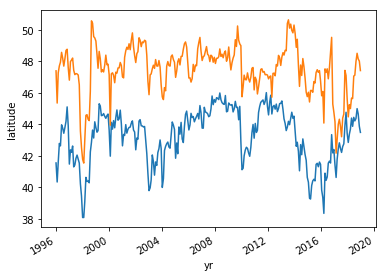

In [73]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from datetime import *; from dateutil.relativedelta import *
import datetime as dt
import pandas as pd

def get_center(rlon):
    if rlon==-165:
        ds_lon = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/MonthlyBifurcationLat165.nc')
    if rlon==-135:
        ds_lon = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/MonthlyBifurcationLat135.nc')
    ds_lon['month']=np.ceil((ds_lon.year-ds_lon.year.astype('int'))*12).astype('int')
    ds_lon['iyear']=ds_lon.year.astype('int')
    ds_lon = ds_lon.assign_coords(yr=ds_lon.year)
    ds_lon = ds_lon.assign_coords(iyear=ds_lon.iyear)
    ds_lon = ds_lon.assign_coords(month=ds_lon.month)
    ds_out = ds_lon.copy(deep=True)    
    ds_lon.close()
    return ds_out

ds=get_center(-165)
ds2=get_center(-135)
tem=[]
for i in range(0,ds.year.size):
    t=str(ds.iyear[i].data)+'-'+str(ds.month[i].data).zfill(2)+'-'+str(15)
    tem.append(np.datetime64(t))
#ds['time']=tem
ds['time']=xr.DataArray(tem,dims=('yr'))
ds['yr']=ds.time
tem=[]
for i in range(0,ds2.year.size):
    t=str(ds2.iyear[i].data)+'-'+str(ds2.month[i].data).zfill(2)+'-'+str(15)
    tem.append(np.datetime64(t))
#ds2['time']=tem
ds2['time']=xr.DataArray(tem,dims=('yr'))
ds2['yr']=ds2.time

ds.latitude.plot()
ds2.latitude.plot()

#ds.latitude.plot()
#ds2.latitude.plot()


In [74]:
mei = xr.open_dataset('F:/data/NASA_biophysical/timeseries_data/imei.nc',decode_times=False)
mei
tdim = mei.time.shape[0]
tt=[]
for i in range(0,tdim):
    tem = dt.datetime(1950,1,15) + relativedelta(months=mei.time[i])
    tt.append(tem)
mei['time2']=tt

C:\Users\gentemann\Miniconda3\lib\site-packages\pandas\io\excel.py:329: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  **kwds)


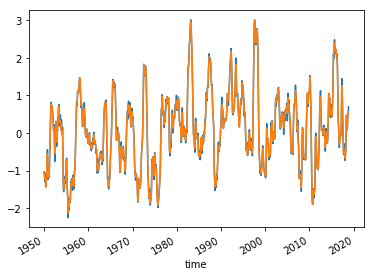

In [75]:
#read in MEI from NOAA, data is given in dec/jan etc. monthly values see: https://www.esrl.noaa.gov/psd/enso/mei/table.html
# assign these 1/1 for dec/jan then create a new time array with 1/15 and interpolate data onto that array
#save interpolated values in ds_mei2
df = pd.read_excel('F:/data/NASA_biophysical/timeseries_data/mei.xlsx', sheetname='Sheet1')
dm = df.values
tm=[]
dm2=[]
for iy in range(0,69):
    for im in range(1,13):
        tt = dt.datetime(dm[iy,0].astype('int'),im,1)
        tm.append(tt)
        dm2.append(dm[iy,im])
ds_mei = xr.DataArray(dm2, coords={'time': tm}, dims=('time'))
ds_mei.plot()
new_time = mei.time2[:].values
new_year = []
for im in range(0,12):
    t = np.datetime64('2018-'+str(im+1).zfill(2)+'-15')
    new_year.append(t)
#xnew = xr.DataArray(new_year,dims='time')
#print(new_time)
#print(xnew)
new_t = np.concatenate((new_time,new_year))
ds_mei2 = ds_mei.interp(time=new_t)
ds_mei2.plot()

In [78]:

ds_mei2

<xarray.DataArray (time: 828)>
array([-1.076516, -1.208   , -1.187258, ...,  0.571871,       nan,       nan])
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2018-12-15

In [80]:
ds_mei_subset = ds_mei2.sel(time=slice(np.datetime64('1996-01-01'),np.datetime64('2018-10-31')))
ds_subset = ds.sel(yr=slice(np.datetime64('1996-01-01'),np.datetime64('2018-10-31')))
ds2_subset = ds2.sel(yr=slice(np.datetime64('1996-01-01'),np.datetime64('2018-10-31')))
norm165 = (ds_subset.latitude-ds_subset.latitude.mean())/ds_subset.latitude.std()
norm135 = (ds2_subset.latitude-ds2_subset.latitude.mean())/ds2_subset.latitude.std()


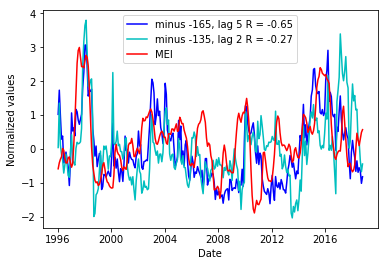

In [82]:
plt.plot(ds_subset.time,-norm165,'b')
plt.plot(ds2_subset.time,-norm135,'c')
plt.plot(ds_mei_subset.time,ds_mei_subset.data,'r')
plt.xlabel('Date')
plt.ylabel('Normalized values')
plt.legend(['minus -165, lag 5 R = -0.65','minus -135, lag 2 R = -0.27','MEI'])
#ds.latitude.plot()
plt.savefig('F:/data/NASA_biophysical/figures/MEI_streamlineLat.png', dpi=100)



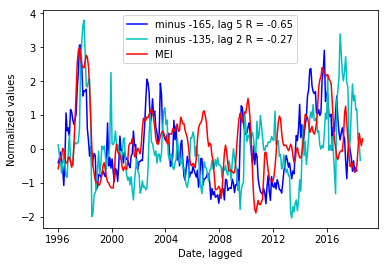

In [83]:
plt.plot(ds_subset.time[0:-7],-norm165[5:-2],'b')
plt.plot(ds2_subset.time[0:-4],-norm135[2:-2],'c')
plt.plot(ds_mei_subset.time[0:-2],ds_mei_subset.data[0:-2],'r')
plt.xlabel('Date, lagged')
plt.ylabel('Normalized values')
plt.legend(['minus -165, lag 5 R = -0.65','minus -135, lag 2 R = -0.27','MEI'])
#ds.latitude.plot()
plt.savefig('F:/data/NASA_biophysical/figures/MEI_streamlineLat_shifted_by_lag.png', dpi=100)

In [87]:
X = np.stack((norm165.data, ds_mei_subset.data), axis=0)
print(np.corrcoef(X)[0,1])
for i in range(1,10):
    X = np.stack((norm165[i:].data, ds_mei_subset[0:-i].data), axis=0)
    print('lag:',i,np.corrcoef(X)[0,1])
X = np.stack((norm165[:].data, ds_mei_subset.data), axis=0)
print(np.corrcoef(X)[0,1])
for i in range(1,10):
    X = np.stack((norm165[0:(-i)].data, ds_mei_subset[i:].data), axis=0)
    print('-lag:',i,np.corrcoef(X)[0,1])


-0.546732084546651
lag: 1 -0.5791470989165286
lag: 2 -0.6121751066891009
lag: 3 -0.6302107771691153
lag: 4 -0.6363379882772298
lag: 5 -0.6411954269954785
lag: 6 -0.6400667902686437
lag: 7 -0.6310037924020951
lag: 8 -0.6036827427904379
lag: 9 -0.548560020944559
-0.546732084546651
-lag: 1 -0.5214025162165032
-lag: 2 -0.4951114718010105
-lag: 3 -0.4491102392583692
-lag: 4 -0.37658577632044626
-lag: 5 -0.2952522218139195
-lag: 6 -0.21824731768269617
-lag: 7 -0.15911991324123165
-lag: 8 -0.12463461814873962
-lag: 9 -0.1114672251826901


In [88]:
X = np.stack((norm135[:].data, ds_mei_subset.data), axis=0)
print(np.corrcoef(X)[0,1])
for i in range(1,10):
    X = np.stack((norm135[i:].data, ds_mei_subset[0:-i].data), axis=0)
    print('lag:',i,np.corrcoef(X)[0,1])
X = np.stack((norm135[:].data, ds_mei_subset.data), axis=0)
print(np.corrcoef(X)[0,1])
for i in range(1,10):
    X = np.stack((norm135[0:(-i)].data, ds_mei_subset[i:].data), axis=0)
    print('-lag:',i,np.corrcoef(X)[0,1])


-0.2571690820916494
lag: 1 -0.2655151874526625
lag: 2 -0.2749869656982922
lag: 3 -0.26693937608979185
lag: 4 -0.24939294963648828
lag: 5 -0.2396936778015236
lag: 6 -0.24190626143532806
lag: 7 -0.24628395094454875
lag: 8 -0.23793116010211898
lag: 9 -0.21372096188549453
-0.2571690820916494
-lag: 1 -0.24718308243239903
-lag: 2 -0.2304293214143017
-lag: 3 -0.19300135606252813
-lag: 4 -0.13025271156741872
-lag: 5 -0.0521711142886752
-lag: 6 0.029118771439928522
-lag: 7 0.08896896711437462
-lag: 8 0.11481630043820275
-lag: 9 0.11411012095952011


In [94]:
#check for time before blob correlations
ds_mei_subset = ds_mei2.sel(time=slice(np.datetime64('1996-01-01'),np.datetime64('2013-10-31')))
ds_subset = ds.sel(yr=slice(np.datetime64('1996-01-01'),np.datetime64('2013-10-31')))
ds2_subset = ds2.sel(yr=slice(np.datetime64('1996-01-01'),np.datetime64('2013-10-31')))
norm165 = (ds_subset.latitude-ds_subset.latitude.mean())/ds_subset.latitude.std()
norm135 = (ds2_subset.latitude-ds2_subset.latitude.mean())/ds2_subset.latitude.std()
X = np.stack((norm135.data, ds_mei_subset.data), axis=0)
print(np.corrcoef(X)[0,1])
for i in range(1,10):
    X = np.stack((norm135[i:].data, ds_mei_subset[0:-i].data), axis=0)
    print('lag:',i,np.corrcoef(X)[0,1])
X = np.stack((norm135[:].data, ds_mei_subset.data), axis=0)
print(np.corrcoef(X)[0,1])
for i in range(1,10):
    X = np.stack((norm135[0:(-i)].data, ds_mei_subset[i:].data), axis=0)
    print('-lag:',i,np.corrcoef(X)[0,1])


-0.26864585926550044
lag: 1 -0.29050411074818583
lag: 2 -0.31413387405560694
lag: 3 -0.3163144842889408
lag: 4 -0.30402178821353654
lag: 5 -0.29268576233788923
lag: 6 -0.2794134348799994
lag: 7 -0.25505141292343475
lag: 8 -0.21461277063475076
lag: 9 -0.1567577592060544
-0.26864585926550044
-lag: 1 -0.24627970339576072
-lag: 2 -0.21939345947544833
-lag: 3 -0.1718346287678512
-lag: 4 -0.0977912263117967
-lag: 5 -0.008612240302940555
-lag: 6 0.0740956465914205
-lag: 7 0.13330689401388754
-lag: 8 0.16426510845212502
-lag: 9 0.1652389579582879
